In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
# Here is a service that simply returns your IP address in a JSON

import requests
r = requests.get('https://api.ipify.org?format=json')
j = r.json()
print(j)

{'ip': '104.155.165.251'}


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [4]:
# Load in the data
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)
x_test.shape: (10000, 28, 28)


In [5]:
# the data is only 2D!
# convolution expects height x width x color
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)

(60000, 28, 28, 1)


In [6]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


In [7]:
# Build a simple model
i = Input(shape = x_train[0].shape)
x = Conv2D(32, (3, 3), strides = 2, activation = 'relu')(i)
x = Conv2D(64, (3, 3), strides = 2, activation = 'relu')(x)
x = Conv2D(128, (3, 3), strides = 2, activation = 'relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation = 'softmax')(x)

model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656

In [8]:
# Compile and fit
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
r = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 5, verbose = 2)

Epoch 1/5
1875/1875 - 5s - loss: 0.5253 - accuracy: 0.8062 - val_loss: 0.4020 - val_accuracy: 0.8486
Epoch 2/5
1875/1875 - 5s - loss: 0.3642 - accuracy: 0.8657 - val_loss: 0.3556 - val_accuracy: 0.8696
Epoch 3/5
1875/1875 - 5s - loss: 0.3139 - accuracy: 0.8822 - val_loss: 0.3301 - val_accuracy: 0.8753
Epoch 4/5
1875/1875 - 5s - loss: 0.2810 - accuracy: 0.8950 - val_loss: 0.3012 - val_accuracy: 0.8908
Epoch 5/5
1875/1875 - 5s - loss: 0.2540 - accuracy: 0.9044 - val_loss: 0.2913 - val_accuracy: 0.8956


In [9]:
# Save the model to a temporary directory
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 168
drwxr-xr-x 2 root root   4096 May 19 19:18 assets
-rw-r--r-- 1 root root 161709 May 19 19:18 saved_model.pb
drwxr-xr-x 2 root root   4096 May 19 19:18 variables


In [10]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0519 19:22:35.552752 140077947828096 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/re

In [11]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  29727      0 --:--:-- --:--:-- --:--:-- 29727
OK
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http:/

In [12]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 46 not upgraded.
Need to get 175 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.1.0 [175 MB]
Fetched 175 MB in 3s (63.2 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.1.0_all.deb ...
Unpacking tensorflow-model-server (2.1.0) ...
Setting up tensorflow-model-server (2.1.0) ...


In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [14]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [15]:
!tail server.log

2020-05-19 19:32:29.552990: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-05-19 19:32:29.569301: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:203] Restoring SavedModel bundle.
2020-05-19 19:32:29.604502: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:152] Running initialization op on SavedModel bundle at path: /tmp/1
2020-05-19 19:32:29.611400: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:333] SavedModel load for tags { serve }; Status: success: OK. Took 60699 microseconds.
2020-05-19 19:32:29.612232: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-05-19 19:32:29.612345: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion_model version: 1}
2020-05-19 19:32:29.6133

In [0]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

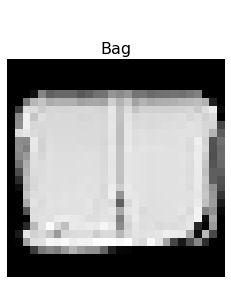

In [17]:
def show(idx, title):
  plt.figure()
  plt.imshow(x_test[idx].reshape(28,28), cmap = 'gray')
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict = {'size': 16})

i = np.random.randint(0, len(x_test))
show(i, labels[y_test[i]])

In [18]:
# Format some data to pass to the server
# {
#   "signature_name": "serving_default",
#   "instances": [ an N x H x W x C list ],
# }

import json
data = json.dumps({"signature_name": "serving_default", "instances": x_test[0:3].tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

In [19]:
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data = data, headers = headers)
j = r.json()
print(j.keys())
print(j)

dict_keys(['predictions'])
{'predictions': [[2.2291016e-07, 3.09955475e-08, 1.81567099e-08, 1.82397724e-08, 8.76268373e-08, 1.46138291e-05, 4.36181189e-08, 0.00102941331, 1.32287539e-06, 0.998954177], [9.28719383e-05, 7.57027294e-08, 0.998376608, 0.000129600579, 0.000691262772, 2.19538294e-11, 0.000709423213, 1.95712825e-12, 7.32187e-08, 3.85659e-11], [2.15620943e-09, 1.0, 9.61031927e-13, 1.93514666e-11, 1.63524611e-10, 1.18679184e-14, 2.30833495e-12, 2.1313137e-19, 2.8250972e-13, 8.32067516e-16]]}


In [20]:
# It looks like a 2-D array, let's check its shape
pred = np.array(j['predictions'])
print(pred.shape)

# This is the N x K output array from the model
# pred[n,k] is the probability that we believe the nth sample belongs to the kth class

(3, 10)


In [0]:
# Get the predicted classes
pred = pred.argmax(axis = 1)

In [22]:
# Map them back to strings
pred = [labels[i] for i in pred]
print(pred)

['Ankle boot', 'Pullover', 'Trouser']


In [23]:
# Get the true labels
actual = [labels[i] for i in y_test[:3]]
print(actual)

['Ankle boot', 'Pullover', 'Trouser']


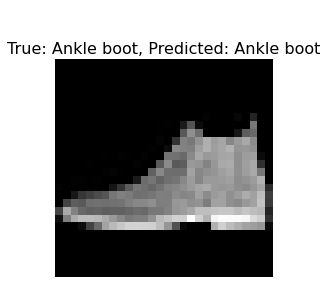

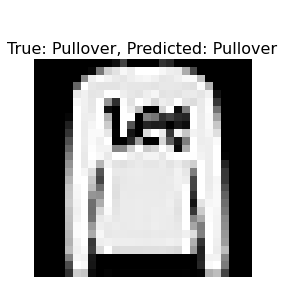

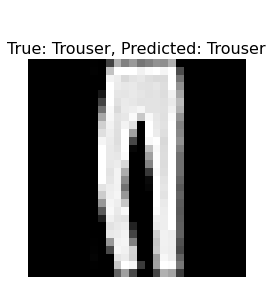

In [24]:
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

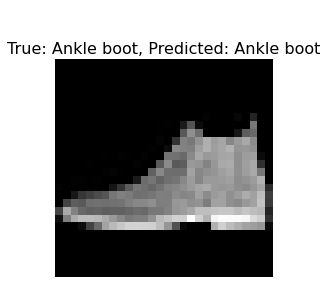

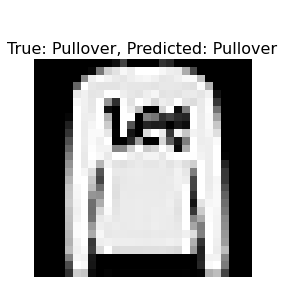

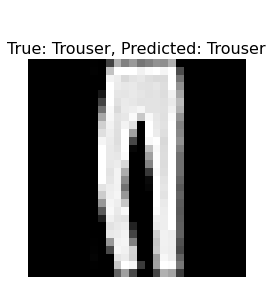

In [25]:
# Allows you to select a model by version

headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data = data, headers = headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis = 1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

In [26]:
# Let's make a new model version
# Build the model using the functional API
i = Input(shape = x_train[0].shape)
x = Conv2D(32, (3, 3), strides = 2, activation = 'relu')(i)
x = Flatten()(x)
x = Dense(K, activation = 'softmax')(x)

model2 = Model(i, x)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compile and fit
# Note: make sure you are using the GPU for this!

model2.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
r = model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 5, verbose = 2)

Epoch 1/5
1875/1875 - 4s - loss: 0.4739 - accuracy: 0.8330 - val_loss: 0.3825 - val_accuracy: 0.8666
Epoch 2/5
1875/1875 - 4s - loss: 0.3353 - accuracy: 0.8818 - val_loss: 0.3438 - val_accuracy: 0.8793
Epoch 3/5
1875/1875 - 4s - loss: 0.2989 - accuracy: 0.8930 - val_loss: 0.3501 - val_accuracy: 0.8755
Epoch 4/5
1875/1875 - 4s - loss: 0.2778 - accuracy: 0.9008 - val_loss: 0.3150 - val_accuracy: 0.8865
Epoch 5/5
1875/1875 - 4s - loss: 0.2600 - accuracy: 0.9072 - val_loss: 0.3041 - val_accuracy: 0.8907


In [28]:
# Save version 2 of the model

version = 2
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model2, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/2

INFO:tensorflow:Assets written to: /tmp/2/assets

Saved model:
total 84
drwxr-xr-x 2 root root  4096 May 19 19:59 assets
-rw-r--r-- 1 root root 77204 May 19 19:59 saved_model.pb
drwxr-xr-x 2 root root  4096 May 19 19:59 variables


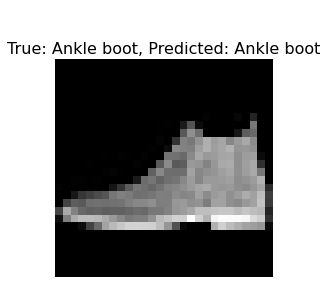

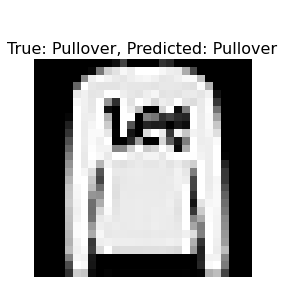

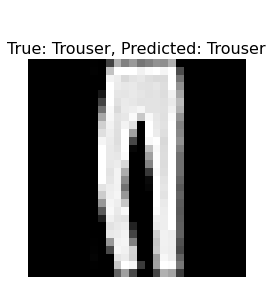

In [29]:
# Will Tensorflow serving know about the new model without restarting?

headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/2:predict', data = data, headers = headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis = 1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

In [30]:
# What if we use a version number that does not exist?

headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/3:predict', data = data, headers = headers)
j = r.json()
print(j)

{'error': 'Servable not found for request: Specific(fashion_model, 3)'}
